In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment', None)
from matplotlib.backends.backend_pdf import PdfPages

In [114]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/4plex/output_data/final_dilutions.csv')
main_data.head()

,patient_id,time_point_days,errors,HRP2_pg_ml,HRP2_pg_ml_dilution,HRP2_pg_ml_well,HRP2_pg_ml_max_dilution,LDH_Pan_pg_ml,LDH_Pan_pg_ml_dilution,LDH_Pan_pg_ml_well,LDH_Pan_pg_ml_max_dilution,LDH_Pv_pg_ml,LDH_Pv_pg_ml_dilution,LDH_Pv_pg_ml_well,LDH_Pv_pg_ml_max_dilution,CRP_ng_ml,CRP_ng_ml_dilution,CRP_ng_ml_well,CRP_ng_ml_max_dilution
0,pa-001,3,NaN,318702.59,2500,e3,312500000.0,142.30,1,g6,312500000.0,15.35,1,g6,312500000.0,5678.58,1.0,g6,312500000.0
1,pa-001,7,NaN,73737.79,2500,c5,125000.0,179.34,1,e12,125000.0,10.31,1,e12,125000.0,1021.09,1.0,e12,125000.0
2,pa-001,14,NaN,4138.79,50,d8,50.0,< 14.41,1,c8,50.0,2.76,1,c8,50.0,7064.05,1.0,c8,50.0
3,pa-001,21,NaN,1377.18,50,d12,50.0,38.94,1,c12,50.0,12.21,1,c12,50.0,2413.65,1.0,c12,50.0
4,pa-001,28,NaN,2024.41,50,h2,50.0,29.86,1,g2,50.0,13.90,1,g2,50.0,92.87,1.0,g2,50.0


In [115]:
analyte_name_dict = {'HRP2_pg_ml': ('HRP2', 'pg/ml'), 'LDH_Pan_pg_ml': ('LDH_Pan', 'pg/ml'),
                     'LDH_Pv_pg_ml': ('LDH_Pv', 'pg/ml'), 'CRP_ng_ml': ('CRP', 'ng/ml')}

In [116]:
analytes = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'LDH_Pv_pg_ml', 'CRP_ng_ml']

In [117]:
def clean_strings(val):
    clean = val.replace('<', '')
    clean = clean.replace('>', '')
    if clean == 'fail':
        return np.nan
    return clean

In [12]:
for analyte in ['HRP2_pg_ml']:
    all_pids = []
    for pid in main_data['patient_id'].unique():
        oh_god = pd.DataFrame(data=[[pid]], columns=['patient_id'])
        pid_data = main_data.loc[main_data['patient_id'] == pid]
        plot_data = pid_data[['patient_id', 'time_point_days', analyte,
                              '{}_dilution'.format(analyte),
                              '{}_max_dilution'.format(analyte)]]
        plot_data[analyte] = plot_data[analyte].apply(clean_strings)
        plot_data[analyte] = plot_data[analyte].apply(float)
        plot_data[analyte] = plot_data[analyte].apply(math.log)
        for timepoint in plot_data['time_point_days']:
            time_val = plot_data.loc[plot_data['time_point_days'] == timepoint,
                                     analyte].item()
            oh_god[timepoint] = time_val
        all_pids.append(oh_god)
    all_pids = pd.concat(all_pids)
all_pids.head()

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,patient_id,3,7,14,21,28,0,35,42,49,56,63,70,77,84,91,98,105,112,119
0,pa-001,12.672014,11.208271,8.328159,7.227793,7.613034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,pa-002,13.743034,12.097918,8.955218,6.642148,5.099805,17.598079,5.861441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,pa-003,NaN,11.906846,9.913953,9.593031,7.988030,12.436586,6.980420,6.069143,3.183870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,pa-004,2.494032,0.067659,0.067659,1.321756,0.067659,10.744872,0.067659,0.067659,0.067659,0.067659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,pa-005,NaN,12.878216,11.534590,11.106011,10.700776,15.878904,9.986338,8.721844,7.732049,8.128963,6.354648,6.034404,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
kmeans = KMeans(n_clusters=2)
test = all_pids.drop('patient_id', axis=1)
test = test.fillna(0)
kmeans.fit(test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
output = kmeans.predict(test)

In [15]:
output

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [22]:
kmeans = all_pids.copy(deep=True)
kmeans['group'] = output
kmeans = kmeans[['patient_id', 'group']]
kmeans.head()

,patient_id,group
0,pa-001,0
0,pa-002,0
0,pa-003,0
0,pa-004,0
0,pa-005,1


In [17]:
for analyte in ['HRP2_pg_ml']:
    pp = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/{}_kmeans_group.pdf'.format(analyte))
    for pid in main_data['patient_id'].unique():
        pid_data = main_data.loc[main_data['patient_id'] == pid]
        plot_data = pid_data[['patient_id', 'time_point_days', analyte,
                              '{}_dilution'.format(analyte),
                              '{}_max_dilution'.format(analyte)]]
        plot_data[analyte] = plot_data[analyte].apply(clean_strings)
        plot_data[analyte] = plot_data[analyte].apply(float)
        plot_data[analyte] = plot_data[analyte].apply(math.log)
        group = check.loc[check['patient_id'] == pid, 'group'].item()
        if group == 0:
            plt_color = 'blue'
        elif group == 1:
            plt_color = 'red'
        f = plt.figure()
        ax = f.add_subplot()
        plt.plot(plot_data['time_point_days'], plot_data[analyte], color=plt_color)
        title = "analyte: {}, patient_id: {}\nkMeans group: {}".format(analyte, pid, group)
        plt.title(title)
        plt.tight_layout()
        pp.savefig(f)
        plt.close()
    pp.close()

In [18]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

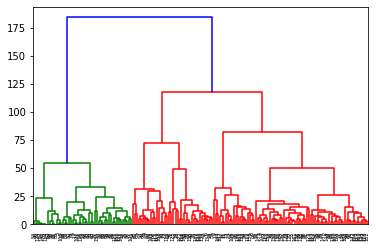

In [20]:
dendrogram = sch.dendrogram(sch.linkage(test, method='ward'))
hc = AgglomerativeClustering(n_clusters=2, affinity='euclidean',
                             linkage='ward')
y_hc = hc.fit_predict(test)

In [21]:
y_hc

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [23]:
hier = all_pids.copy(deep=True)
hier['group'] = y_hc
hier = hier[['patient_id', 'group']]
hier.head()

,patient_id,group
0,pa-001,0
0,pa-002,0
0,pa-003,0
0,pa-004,1
0,pa-005,0


In [25]:
for analyte in ['HRP2_pg_ml']:
    pp = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/{}_hierarchical_group.pdf'.format(analyte))
    for pid in main_data['patient_id'].unique():
        pid_data = main_data.loc[main_data['patient_id'] == pid]
        plot_data = pid_data[['patient_id', 'time_point_days', analyte,
                              '{}_dilution'.format(analyte),
                              '{}_max_dilution'.format(analyte)]]
        plot_data[analyte] = plot_data[analyte].apply(clean_strings)
        plot_data[analyte] = plot_data[analyte].apply(float)
        plot_data[analyte] = plot_data[analyte].apply(math.log)
        group = check.loc[check['patient_id'] == pid, 'group'].item()
        if group == 0:
            plt_color = 'blue'
        elif group == 1:
            plt_color = 'red'
        f = plt.figure()
        f.add_subplot()
        plt.plot(plot_data['time_point_days'], plot_data[analyte], color=plt_color)
        title = "analyte: {}, patient_id: {}\nHierarchical group: {}".format(analyte, pid, group)
        plt.title(title)
        plt.tight_layout()
        pp.savefig(f)
        plt.close()
    pp.close()